# Demonstration of the OPERA frame definition

In [3]:
import sqlite3
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import geoplot as gplt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def _setup_spatialite_con(con):
    con.enable_load_extension(True)
    # Try the two versions, mac and linux with .so
    try:
        con.load_extension("mod_spatialite")
    except:
        con.load_extension("mod_spatialite.so")
    # Allow us to use spatialite functions in on GPKG files.
    # https://medium.com/@joelmalone/sqlite3-spatialite-and-geopackages-66a08485da6c
    con.execute("SELECT EnableGpkgAmphibiousMode();")
    

# Load the burst/frame geometries

In [7]:
%%time

database_path = "s1-frames-11frames-1overlap.gpkg"
# Load a subset of all attributes for demonstration
sql = """
SELECT 
    f.relative_orbit_number,
    f.frame_number,
    b.burst_id,
    f.epsg as frame_epsg,
    b.epsg as burst_epsg,
    b.OGC_FID as pkey_burst,
    f.fid as pkey_frame,
    burst_id_jpl,
    AsBinary(b.geom) as geom,
    AsBinary(f.geom) as frame_wkb
FROM burst_id_map b
JOIN frames_bursts fb ON b.OGC_FID = fb.burst_ogc_fid
JOIN frames f ON f.fid = fb.frame_fid
"""

with sqlite3.connect(database_path) as con:
    _setup_spatialite_con(con)
    df = gpd.GeoDataFrame.from_postgis(sql, con, geom_col="geom", crs=4326)


#
gs_frame = gpd.GeoSeries.from_wkb(df.frame_wkb)
df["geom_frame"] = gs_frame
df.drop(["frame_wkb"], axis='columns', inplace=True)
df.head()

CPU times: user 11.2 s, sys: 1.01 s, total: 12.2 s
Wall time: 12.8 s


,relative_orbit_number,frame_number,burst_id,frame_epsg,burst_epsg,pkey_burst,pkey_frame,burst_id_jpl,geom,geom_frame
0,1,1,1,32631,32631,1,1,t001_000001_iw1,"MULTIPOLYGON Z (((3.36758 0.75322 0.00000, 3.7...","POLYGON Z ((3.33269 0.92005 0.00000, 3.32957 0..."
1,1,1,1,32631,32631,2,1,t001_000001_iw2,"MULTIPOLYGON Z (((4.09178 0.97402 0.00000, 4.5...","POLYGON Z ((3.33269 0.92005 0.00000, 3.32957 0..."
2,1,1,1,32631,32631,3,1,t001_000001_iw3,"MULTIPOLYGON Z (((4.85545 1.19200 0.00000, 5.2...","POLYGON Z ((3.33269 0.92005 0.00000, 3.32957 0..."
3,1,1,2,32631,32631,4,1,t001_000002_iw1,"MULTIPOLYGON Z (((3.33269 0.92005 0.00000, 3.7...","POLYGON Z ((3.33269 0.92005 0.00000, 3.32957 0..."
4,1,1,2,32631,32631,5,1,t001_000002_iw2,"MULTIPOLYGON Z (((4.05690 1.14071 0.00000, 4.4...","POLYGON Z ((3.33269 0.92005 0.00000, 3.32957 0..."


In [87]:
print("Number of total (track, frame) pairs:")
print(len(df[["relative_orbit_number", "frame_number"]].groupby(["relative_orbit_number", "frame_number"]).count()))

Number of total (track, frame) pairs:
37625


## Some summary statistics about the frames

In [35]:
grouped = df[["relative_orbit_number", "frame_number", "burst_id"]].groupby(["relative_orbit_number", "frame_number"], as_index=False)

burst_count_by_frame = grouped.count()
burst_count_by_frame[['frame_number', 'burst_id']]\
    .rename({"burst_id": "burst_count", "frame_number": "number of frames"}, axis='columns')\
    .groupby("burst_count")\
    .count()


,number of frames
burst_count,
21,13
24,162
33,37450


## Plots

In [4]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

In [53]:
gs_frame_unique = gpd.GeoSeries(gs_frame.unique())

### First 645 frames, spanning Tracks 1 - 3

<GeoAxesSubplot: >

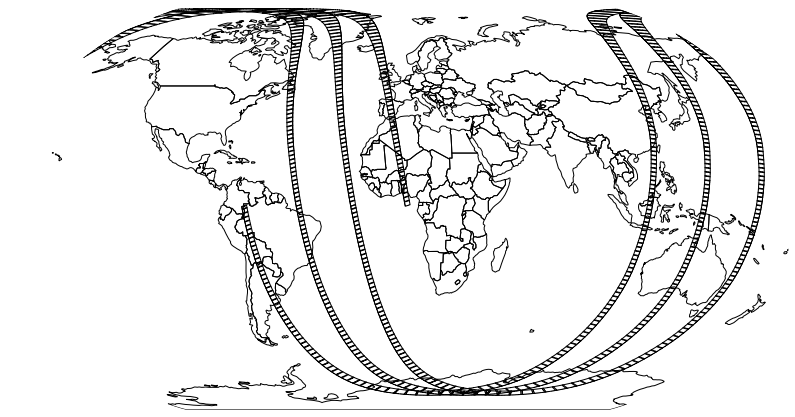

In [92]:
ax = gplt.polyplot(world, projection=gplt.crs.Orthographic(), figsize=(14, 8));
gplt.polyplot(gs_frame_unique.iloc[:645], ax=ax)


/Users/staniewi/miniconda3/envs/mapping/lib/python3.10/site-packages/geoplot/geoplot.py:703: UserWarning: Plot extent lies outside of the Orthographic projection's viewport. Defaulting to global extent.
  warnings.warn(


<GeoAxesSubplot: >

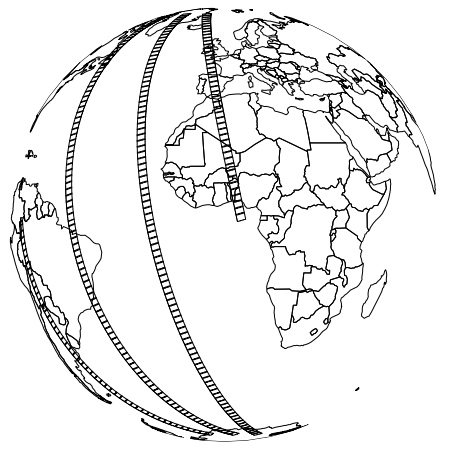

In [93]:
ax = gplt.polyplot(world, projection=gplt.crs.Orthographic(), figsize=(14, 8));
gplt.polyplot(gs_frame_unique.iloc[:645], ax=ax)


### Fixed frames numbers for all tracks

These will be at the same latitude, since the `frame_number` resets to 1 at the equator.

In [76]:
gs_unique2 = df[df.frame_number.isin([1, 10, 50, 100, 200])].geom_frame.unique()
gs_unique2 = gpd.GeoSeries(gs_unique2)

<GeoAxesSubplot: >

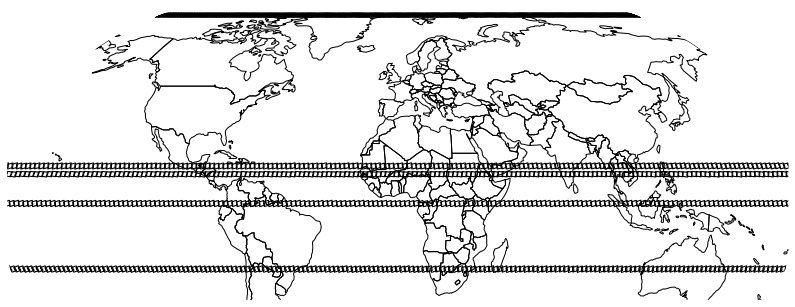

In [77]:
ax = gplt.polyplot(world, projection=gplt.crs.Robinson(), figsize=(14, 8));
gplt.polyplot(gs_unique2, ax=ax)


# Map projections used

- Above +84 latitude, we use [3413](https://epsg.org/crs_3413/WGS-84-NSIDC-Sea-Ice-Polar-Stereographic-North.html)
    - Exception: We **project all of Greenland to EPSG 3413**
- Below -60 latitude, we use [3031](https://epsg.org/crs_3031/WGS-84-Antarctic-Polar-Stereographic.html)
- All other **latitudes (-60, 84)**, we choose the corresping UTM Zone
    - These are codes 32601-32660 for northern hemisphere, 32701-32760 for southern hemisphere
    - Note that going up to 84 means Alaska is all UTM, but stopping at -60 means Antarctica is in Stereographic Polar
    

## How are the EPSG codes determined for the bursts
1. The Frame EPSG is found using **the centroid of the frame**. 
    - We get its UTM zone using [the UTM library to convert](https://github.com/Turbo87/utm) to avoid the weird edge cases near Norway and Svalbard: http://www.jaworski.ca/utmzones.htm
    - Note that extra care is taken at the antimeridian due to the split MultiPolygons

2. Each burst then uses the EPSG of the frame that they are a part of
    - This lowers the number of reprojections needed when doing frame-based processing


## What about at the overlapping bursts at UTM zone crossings?


Every 11 bursts is a part of 2 adjacent frames. 
For the 3 bursts in the overlap of frames that switch UTM zones, **they use the later frame** (the one with the higher number).
This was an arbitrary decision to use the later vs the earlier frame's EPSG.

### Example


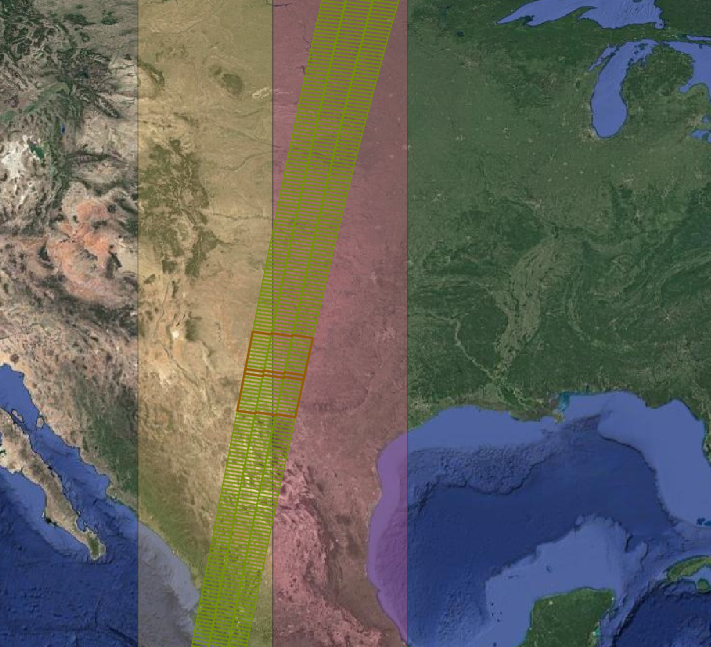

We have two frames in the Descending portion of Track 12 whose centroids cross from UTM 14N (top) to UTM 13N (bottom).

In [94]:

sql = """
SELECT 
    f.relative_orbit_number,
    f.frame_number,
    b.burst_id,
    f.epsg as frame_epsg,
    b.epsg as burst_epsg,
    burst_id_jpl,
    b.OGC_FID as pkey_burst,
    f.fid as pkey_frame,
    AsBinary(b.geom) as geom,
    AsBinary(f.geom) as frame_wkb
FROM burst_id_map b
JOIN frames_bursts fb ON b.OGC_FID = fb.burst_ogc_fid
JOIN frames f ON f.fid = fb.frame_fid
WHERE f.relative_orbit_number = 12
    AND f.frame_number BETWEEN 89 and 90
"""
with sqlite3.connect(database_path) as con:
    _setup_spatialite_con(con)
    # print(pd.read_sql(sql, con).columns)
    df_cross = gpd.GeoDataFrame.from_postgis(sql, con, geom_col="geom", crs=4326)


#
gs_frame_cross = gpd.GeoSeries.from_wkb(df_cross.frame_wkb)
df_cross["geom_frame"] = gs_frame_cross
df_cross.drop(["frame_wkb"], axis='columns', inplace=True)
df_cross.head()

,relative_orbit_number,frame_number,burst_id,frame_epsg,burst_epsg,burst_id_jpl,pkey_burst,pkey_frame,geom,geom_frame
0,12,89,24508,32614,32614,t012_024508_iw1,73522,2454,"MULTIPOLYGON Z (((-100.21302 32.71596 0.00000,...","POLYGON Z ((-102.42891 31.02373 0.00000, -102...."
1,12,89,24508,32614,32614,t012_024508_iw2,73523,2454,"MULTIPOLYGON Z (((-101.10778 32.79268 0.00000,...","POLYGON Z ((-102.42891 31.02373 0.00000, -102...."
2,12,89,24508,32614,32614,t012_024508_iw3,73524,2454,"MULTIPOLYGON Z (((-102.04627 32.88039 0.00000,...","POLYGON Z ((-102.42891 31.02373 0.00000, -102...."
3,12,89,24509,32614,32614,t012_024509_iw1,73525,2454,"MULTIPOLYGON Z (((-100.25118 32.54983 0.00000,...","POLYGON Z ((-102.42891 31.02373 0.00000, -102...."
4,12,89,24509,32614,32614,t012_024509_iw2,73526,2454,"MULTIPOLYGON Z (((-101.14419 32.62657 0.00000,...","POLYGON Z ((-102.42891 31.02373 0.00000, -102...."


In [95]:
df_cross[df_cross.columns[:6]].iloc[27:39]

,relative_orbit_number,frame_number,burst_id,frame_epsg,burst_epsg,burst_id_jpl
27,12,89,24517,32614,32614,t012_024517_iw1
28,12,89,24517,32614,32614,t012_024517_iw2
29,12,89,24517,32614,32614,t012_024517_iw3
30,12,89,24518,32614,32613,t012_024518_iw1
31,12,89,24518,32614,32613,t012_024518_iw2
32,12,89,24518,32614,32613,t012_024518_iw3
33,12,90,24518,32613,32613,t012_024518_iw1
34,12,90,24518,32613,32613,t012_024518_iw2
35,12,90,24518,32613,32613,t012_024518_iw3
36,12,90,24519,32613,32613,t012_024519_iw1


Note that `burst_id_jpl=t012_024518_iw1` is repeated on rows 30 and 33.

Even though the burst is in the frame whose EPSG is 32614 (row 30), **the assigned burst EPSG is 32613**.

# Extra Details

## How does the frame size and overlap size affect the final frame leftover size?

There are 375,887 distinct burst IDs (triples of IW1,2,3), for a total of 1,127,661 bursts.

- If we were to assign a "frame number" that starts at 1 per track, the total number of bursts may not be evenly divisible.

- We wouldn't want frames of only 1 or 2 bursts.
- We also don't want humongous frames
    - The only evenly divisible number is 17 bursts. Too large for a frame.

In [102]:
from collections import Counter
import numpy as np
from burst_db.make_frame_db import _make_frame_slices

df_burst_count_per_track = df[['relative_orbit_number', 'burst_id']].groupby('relative_orbit_number').burst_id.nunique()
burst_count_per_track = df_burst_count_per_track.to_dict()


results = []
for n_bursts_per_frame in [9, 10, 11, 12, 13]:
    for overlap in [1, 2]:
        track_to_slices = {}
        for track, count in burst_count_per_track.items():
            b = np.arange(count)
            slices = _make_frame_slices(count, n_bursts_per_frame=n_bursts_per_frame, overlap=overlap)
            track_to_slices[track] = len(b[slices[-1]])

        for (leftover, count) in Counter(track_to_slices.values()).items():
            results.append((n_bursts_per_frame, overlap, leftover, count))
pd.DataFrame(results, columns=['n_bursts_per_frame', 'overlap', 'leftover', 'count'])

,n_bursts_per_frame,overlap,leftover,count
0,9,1,4,162
1,9,1,3,13
2,9,2,6,162
3,9,2,5,13
4,10,1,6,162
5,10,1,5,13
6,10,2,4,162
7,10,2,3,13
8,11,1,8,162
9,11,1,7,13


- Here the `leftover` column means the number of along-track bursts in the final frame of a relative orbit. 
- The `count` is the number of relative orbits (out of 175) which have that final frame count

Choosing 11 bursts per frame and 1 overlap means that the final frames all 7 or 8 bursts along-track.

## Database layout

Because we are overlapping frames, not only does a frame have multiple bursts, but a burst can have multiple frames.
This means we have a [many-to-many relationship](https://support.airtable.com/docs/airtable-s-guide-to-many-to-many-relationships#manytomany-relationships-and-junction-tables) between  `Frames` and `Bursts`.

Our database has a join table (also known as a mapping table, or a junction table), called `frames_bursts` containing the primary keys of the tables representing `Bursts` and `Frames`. 

In [99]:
with sqlite3.connect(database_path) as con:
    df_join = pd.read_sql("SELECT * from frames_bursts limit 5", con)
    df_join = df_join.set_index("index")
df_join

,frame_fid,burst_ogc_fid
index,,
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


Since this table has a row for ever (frame, burst) combination, it has more entries than the total number of unique bursts:

In [100]:
print("Number of unique bursts:")
print(len(df.burst_id_jpl.unique()))


Number of unique bursts:
1127661


In [101]:
print("Number of (frame, burst) pairs:")
print(len(df))


Number of (frame, burst) pairs:
1240011
